Libraries import

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Note: if the `seaborn` plots do not work properly, restart the kernel after running the installation below.

In [2]:
! pip install -U seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.1)


In [3]:
import datetime

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

%matplotlib inline
import seaborn as sns 
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (18.0, 6.0)

In [4]:
# sns.set_palette(["#3f3e6fd1", "#85c6a9"])
sns.set_palette(["teal", "olive"])

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc, asc, col, count, when, isnan, lit, unix_timestamp, stddev
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

<img src="https://miro.medium.com/max/988/1*vyXO4v0OQsmcctUcx6jL3w.png" width="800px">

# Sparkify Music Streaming Platform - User Churn prediction
___


## 1. Business Understanding
___


Sparkify is a music streaming platform similar to Spotify or YouTube Music. It is crucial for a platform like this to make sure the users like the service and will keep using it.

Given the users traffic on the platform, the purpose of the project is to predict user churn. A churned user is a user who has stopped using an app or more accurately in our case, canceled its account.

After prediction, the platform can take action to keep the users prone to cancellation and give them, for instance, custom discounts or support.

## 2. Data Understanding
___

### 2.1. Importing the data source

First, we will create a Spark session

In [6]:
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

In [7]:
spark

In [8]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [9]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 2.2. A first look on the data
___

In [10]:
user_log.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

Number of actions in the dataset:

In [11]:
user_log.count()

286500

Creating a temporary table to query

In [12]:
user_log.createOrReplaceTempView("user_log_table")

Number of users in the dataset:

In [13]:
spark.sql('''
          SELECT 
              COUNT(DISTINCT userId)   AS users
          FROM user_log_table
          '''
         ).show()

+-----+
|users|
+-----+
|  226|
+-----+



Columns summary:

In [14]:
user_log.describe().select('summary', 'artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location').show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|249.1171819778458|  null|             null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|99.23517921058361|  null|             null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|          0.78322|  free|       Albany, OR|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|       3024.66567|  

In [15]:
user_log.describe().select('summary', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId').show()

+-------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|286500| 286500|              278154|           286500|              228108|            286500|              286500|              278154|           286500|
|   mean|  null|   null|1.535358834084427...|1041.526554973822|            Infinity|210.05459685863875|1.540956889810483...|                null|59682.02278593872|
| stddev|  null|   null| 3.291321616327586E9|726.7762634630741|                 NaN| 31.50507848842214|1.5075439608226302E9|                null|109091.9499991047|
|    min|   GET|

Missing values:
- for ~20% of the records, *artist*, *length* and *song* are missing, which means the actions are not related to listening to music, as shown below; these nulls are not meant to be filled
- for ~3% of the records we do not have authenticated users (*firstName*, *gender*, *lastName*, *location*, *registration* and *userAgent* are missing) - these records will be excluded in the data preparation step

In [16]:
spark.sql('''
          SELECT DISTINCT
              page
          FROM user_log_table
          WHERE artist IS NOT NULL OR length IS NOT NULL OR song IS NOT NULL
          '''
         ).show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



## 3. Data Preparation
___


#### Define Churn

At this step we will define churn, to be used as the label for our model. A churned user is a user who cancelled the account, so the `churn_flag` will be `1` for a user that has arrived on a `Cancellation Confirmation` page.

Also, actions of unauthenticated users will be filtered, considering we want to classify users of the platform.

In [17]:
user_log = spark.sql('''
          WITH churn AS (
              SELECT
                  userId,
                  MAX(IF(page = 'Cancellation Confirmation', 1, 0)) AS churn_flag
              FROM user_log_table
              GROUP BY
                  userId
         )
         SELECT 
             user.userId, 
             artist, 
             auth, 
             firstName, 
             gender, 
             itemInSession, 
             lastName, 
             length, 
             level, 
             location, 
             method, 
             page, 
             registration, 
             sessionId, 
             song, 
             status, 
             ts, 
             userAgent,
             churn.churn_flag
         FROM user_log_table AS user
         JOIN churn
             ON user.userId = churn.userId
         WHERE registration IS NOT NULL
         '''
         )

## 4. Analysis of the given variables
___

Updating the temporary table, so that we will query the data we just processed.

In [18]:
user_log.createOrReplaceTempView("user_log_table")

In [19]:
users_df = spark.sql('''
                     SELECT DISTINCT
                         userId,
                         churn_flag
                     FROM user_log_table
                    '''
                    )

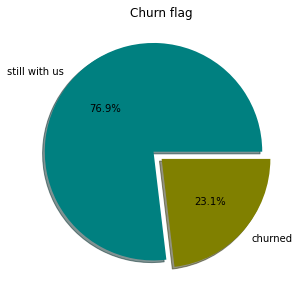

In [20]:
fig = plt.figure(figsize=(20, 5))
users_df.toPandas().churn_flag.value_counts().plot.pie(labels=['still with us', 'churned'], 
                                                       autopct='%.1f%%', 
                                                       explode=(0.1, 0), 
                                                       shadow=True
                                                      )
plt.xticks(rotation=False)
plt.title('Churn flag')
plt.ylabel('')
plt.show()

We can easily notice that classes are inbalanced. Keeping this in mind and considering our task, the objective will be to get a good precision score for the negative class (`churn_flag=1`).

Below there are defined functions to use for plotting 
- the variables/metrics with respect to the churn flag
    - `plot_hist` for continuous variables
    - `plot_bar` for categorical variables
- the correlation matrices - `plot_heatmap`

In [21]:
def plot_hist(df, variable_name):
    '''
    Plots a histogram for a continuous variable with respect to the churn flag using seaborn
    
    Input
    -----
    df: Pandas DataFrame
        dataframe containing the churn flag and the variable to be plotted
    variable_name: string
        variable to be plotted
    '''
    plt.figure(figsize=(15, 8))
    sns.histplot(data=df, x=variable_name, hue='churn_flag', element='poly', palette = ["teal", "olive"])
    sns.histplot(data=df, x=variable_name, hue='churn_flag', element='poly', palette = ["teal", "olive"])
    plt.ylabel('Number of users')
    plt.legend(['churned', 'still with us'])
    plt.title(variable_name.upper())
    plt.show()

In [22]:
def plot_bar(df, variable_name):
    '''
    Plots a bar plot for a categorical variable with respect to the churn flag using seaborn
    
    Input
    -----
    df: Pandas DataFrame
        dataframe containing the churn flag and the variable to be plotted
    variable_name: string
        variable to be plotted
    '''
    fig = plt.figure(figsize=(7, 5))
    sns.countplot(x = variable_name, hue = 'churn_flag', data = df, palette = ["teal", "olive"])   
    plt.ylabel('Number of users')
    plt.legend(['still with us', 'churned'])
    plt.title(f'Number of a active/churn users by {variable_name}')
    plt.tight_layout()
    plt.show()

In [23]:
def plot_heatmap(df):
    '''
    Plots a correlation matrix using seaborn's heatmap
    
    Input
    -----
    df: Pandas DataFrame
        dataframe containing correlations to be plotted
    '''
    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.heatmap(df.round(2),
                     annot=True,
                     fmt='g',
                     cmap = 'Pastel2_r',
                     linewidths=.5)
    sns.set(font_scale=1)
    plt.title('Correlation Matrix')
    plt.show()

### 4.1. Gender
___

In [24]:
gender_df = spark.sql('''
                      SELECT DISTINCT
                          userId,
                          gender,
                          churn_flag
                      FROM user_log_table
                      '''
                     ).toPandas()

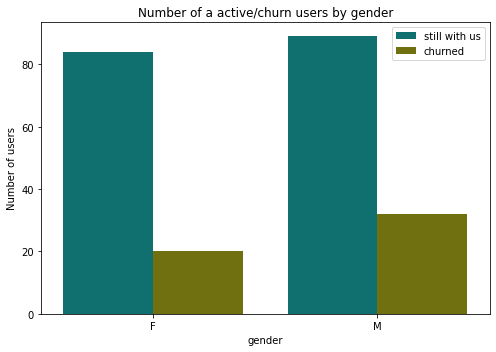

In [25]:
plot_bar(gender_df, 'gender')

It looks like the gender does not determine user churn and therefore I will choose not to use it as a feature for the moment.

### 4.2. First Name, Last Name
___

We will assume user names are not the most insightful information in the dataset considering our scope, so I will choose to skip data analysis for this ones, for the moment.

### 4.3. Location
___

In [26]:
locations = spark.sql('''
                      SELECT
                          location,
                          COUNT(DISTINCT userId)   AS users
                      FROM user_log_table
                      GROUP BY 
                          location
                      ORDER BY users DESC
                      '''
                     )

In [27]:
locations.show(5)

+--------------------+-----+
|            location|users|
+--------------------+-----+
|Los Angeles-Long ...|   16|
|New York-Newark-J...|   15|
|Phoenix-Mesa-Scot...|    7|
|Dallas-Fort Worth...|    7|
|Chicago-Napervill...|    6|
+--------------------+-----+
only showing top 5 rows



In [28]:
locations.count()

114

In the given dataset, there are users from many locations, therefore `location` in this form may not be a good idea to use as a feature for the model. However, it could be interesting to find a way to aggregate the locations. Below I extracted `state` from `location` string:

In [29]:
states = spark.sql('''
              SELECT
                  RIGHT(location, 2)        AS state,
                  COUNT(DISTINCT userId)    AS users
              FROM user_log_table
              GROUP BY 
                  state
              ORDER BY users DESC
              '''
             )

In [30]:
states.show(10)

+-----+-----+
|state|users|
+-----+-----+
|   CA|   33|
|   PA|   18|
|   TX|   16|
|   FL|   14|
|   WI|   10|
|   IL|    9|
|   NC|    9|
|   SC|    8|
|   CT|    7|
|   MD|    7|
+-----+-----+
only showing top 10 rows



In [31]:
states.count()

39

There are still many locations, considering the number of users in our dataset. For future research, we could use location as a feature if states can be grouped, for example in northern/southern/western/eastern states or a bigger dataset could be used. I will choose not to use it as a feature for the moment.

### 4.4. Song related variables: *Artist*, *Song*, *Length*
___

In [32]:
music_df = spark.sql('''
                  SELECT
                      userId,
                      churn_flag,
                      COUNT(*)                                     AS actions,
                      COUNT(song)                                  AS plays,
                      COUNT(DISTINCT song)                         AS songs,
                      COUNT(DISTINCT artist)                       AS artists,
                      SUM(length)                                  AS total_length
                  FROM user_log_table
                  GROUP BY
                      userId,
                      churn_flag
                  '''
                 )

In [33]:
music_df.show()

+------+----------+-------+-----+-----+-------+------------------+
|userId|churn_flag|actions|plays|songs|artists|      total_length|
+------+----------+-------+-----+-----+-------+------------------+
|    19|         0|    259|  216|  209|    197|54480.933869999986|
|100005|         1|    216|  154|  153|    149| 37037.12201000001|
|200007|         0|     76|   65|   65|     64|15739.869310000002|
|300007|         1|    143|  111|  111|    107| 28028.71048000002|
|200002|         0|    474|  387|  378|    339| 94008.87593999993|
|    50|         0|    651|  503|  476|    423|122751.27560999991|
|    30|         0|   1775| 1417| 1272|   1018| 359808.2456399997|
|     8|         0|    334|  251|  244|    230| 63393.53190999996|
|100012|         1|    600|  476|  453|    397|115503.35311000001|
|100011|         1|     23|   11|   11|     11|         2841.6995|
|     4|         0|   2442| 2048| 1799|   1342|506140.04138000077|
|    65|         0|   2544| 2113| 1837|   1377| 529357.9054199

In [34]:
music_pd_df = music_df.toPandas()

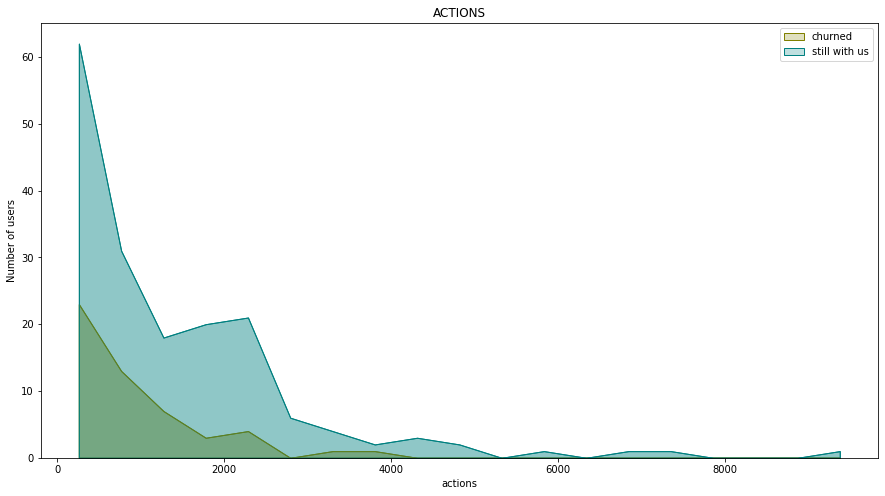

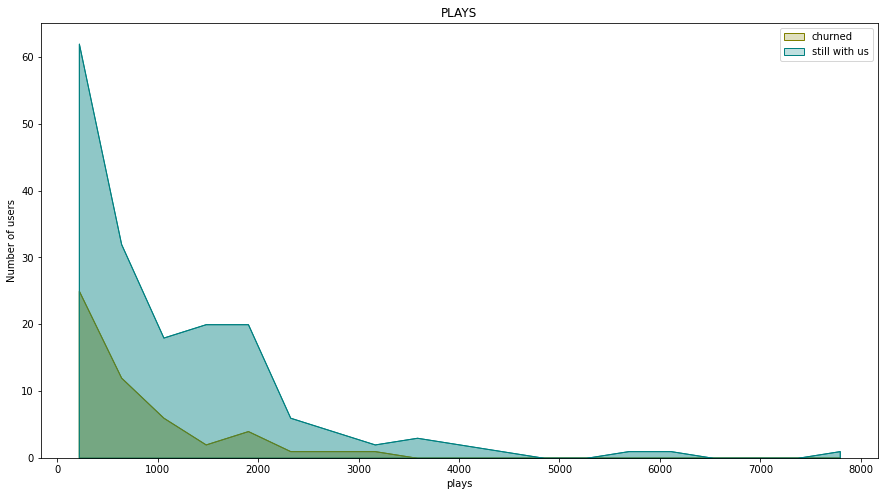

In [35]:
plot_hist(music_pd_df, 'actions')
plot_hist(music_pd_df, 'plays')

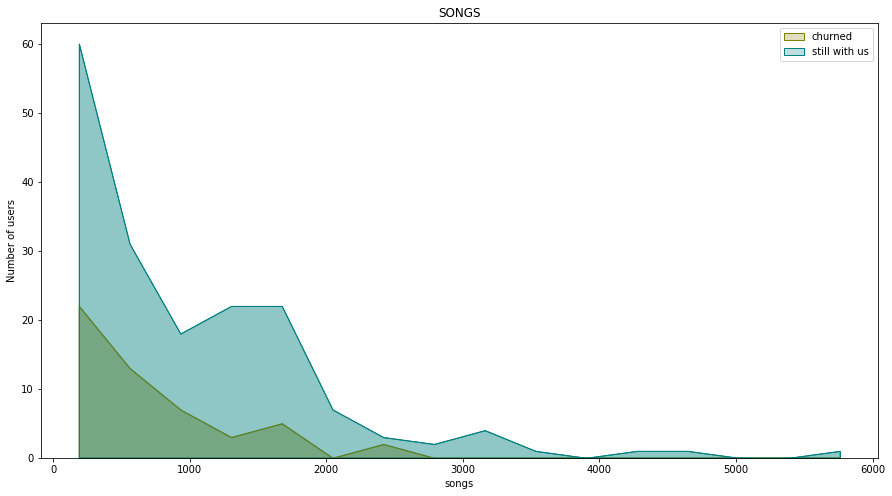

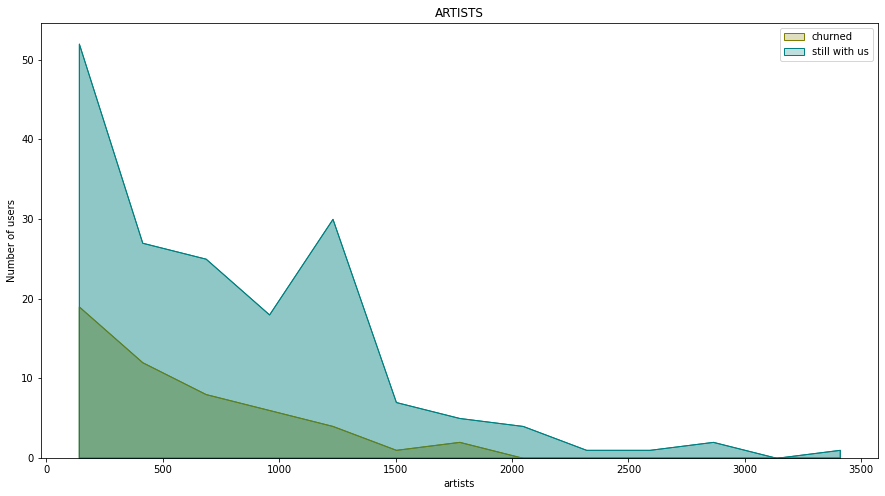

In [36]:
plot_hist(music_pd_df, 'songs')
plot_hist(music_pd_df, 'artists')

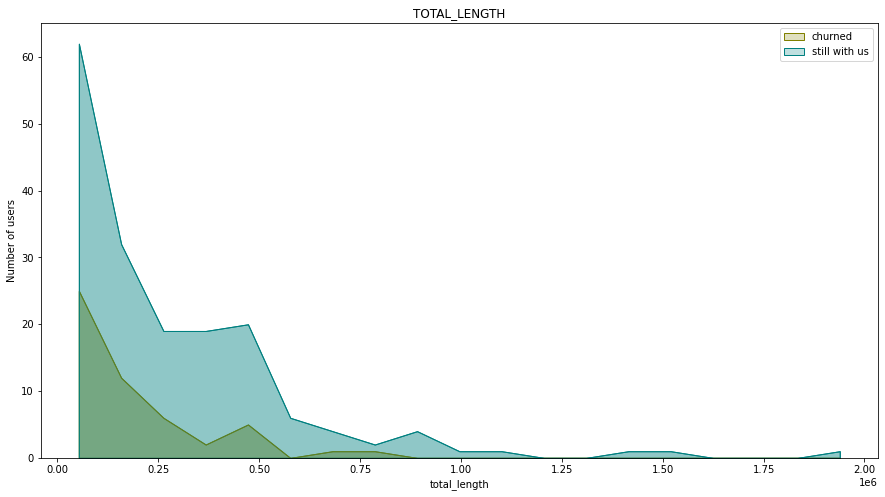

In [37]:
plot_hist(music_pd_df, 'total_length')

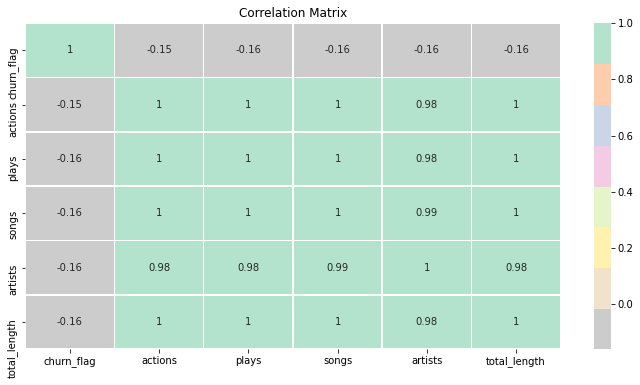

In [38]:
plot_heatmap(music_pd_df.corr())

It is noticeable that the pattern is similar for *actions*, *plays*, *songs* and *length* plots and this is confirmed by the high values of correlations. Therefore, we can consider enough to add to the model features just one variable from this list.

### 4.5. Level
___

In [39]:
spark.sql('''
          SELECT DISTINCT
              level
          FROM user_log_table
          '''
         ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



`level` represents the plan the user has

It is a common behaviour for a user to try both `paid` and `free` levels. We can analyze the most recent level, since it better defines an user at the present moment or at the moment of churn.


In [40]:
levels_df = spark.sql('''
              SELECT DISTINCT
                  userId,
                  churn_flag,
                  LAST_VALUE(level) OVER (PARTITION BY userId ORDER BY ts ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)   AS last_level
              FROM user_log_table
          '''
         )

In [41]:
levels_df.show()

+------+----------+----------+
|userId|churn_flag|last_level|
+------+----------+----------+
|100010|         0|      free|
|200002|         0|      paid|
|   125|         1|      free|
|   124|         0|      paid|
|    51|         1|      paid|
|     7|         0|      free|
|    15|         0|      paid|
|    54|         1|      paid|
|   155|         0|      paid|
|100014|         1|      paid|
|   132|         0|      paid|
|   154|         0|      free|
|   101|         1|      paid|
|    11|         0|      paid|
|   138|         0|      paid|
|300017|         0|      paid|
|100021|         1|      free|
|    29|         1|      paid|
|    69|         0|      paid|
|   112|         0|      free|
+------+----------+----------+
only showing top 20 rows



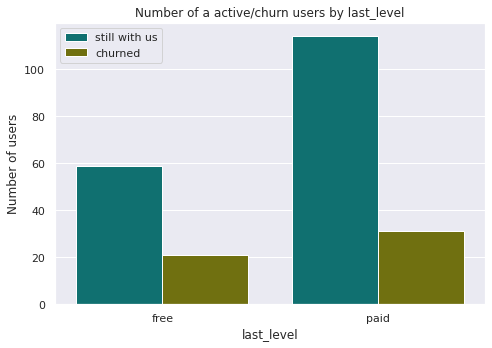

In [42]:
plot_bar(levels_df.toPandas(), 'last_level')

It looks like an user is more likely to stay with us if purchased a paid subscription, so `last level` can be an interesting feature to be added in our model.

### 4.6. User Agent
___

In [43]:
user_agents = spark.sql('''
                        SELECT DISTINCT
                            userAgent
                        FROM user_log_table
                        '''
                       )

In [44]:
user_agents.count()

56

In [45]:
if user_agents.count() < 100:
    user_agents.show(user_agents.count(), truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |
|"Mozi

User agents are diverse and there are low chances to help us predict user churn in this form. We can extract the operating system from `userAgent` and see if this gives us more insight.

In [46]:
operating_systems_df = spark.sql('''
                            SELECT DISTINCT
                                userId,
                                churn_flag,
                                CASE 
                                    WHEN LOWER(userAgent) LIKE '%mac%' 
                                        THEN 'Mac OS'
                                    WHEN LOWER(userAgent) LIKE '%windows%'
                                        THEN 'Windows'
                                    WHEN LOWER(userAgent) LIKE '%linux%'
                                        THEN 'Linux'
                                END  
                                    AS operating_system
                            FROM user_log_table
                            '''
                           ).toPandas()

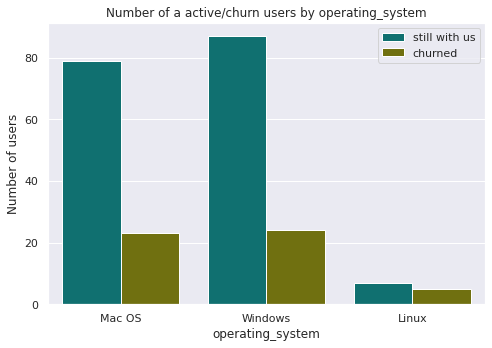

In [47]:
plot_bar(operating_systems_df, 'operating_system')

It looks like we have just a few users that are using Linux and those tend to cancel the account more than users that prefer Mac or Windows. However, the number of users in our dataset is low and also the number of Linux users all over the world is low compared to other operating systems. Therefore, it may be not a good idea to rely on this feature or on other features engineered from `userAgent`, for the moment.

### 4.7.Status, Auth, Method
___

In [48]:
spark.sql('''
          SELECT DISTINCT
              status
          FROM user_log_table
          '''
         ).show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [49]:
spark.sql('''
          SELECT DISTINCT
              auth
          FROM user_log_table
          '''
         ).show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [50]:
spark.sql('''
          SELECT DISTINCT
              method
          FROM user_log_table
          '''
         ).show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



These columns are related to the HTTP status code, authentication status, HTTP methods and it should not be of interest for our scope.

### 4.8. Page
___

In [51]:
pages_df = spark.sql('''
                     SELECT 
                         page,
                         COUNT(*)        AS actions
                     FROM user_log_table
                     GROUP BY
                         page
                     '''
                    )

In [52]:
pages_df.show(truncate=False)

+-------------------------+-------+
|page                     |actions|
+-------------------------+-------+
|Cancel                   |52     |
|Submit Downgrade         |63     |
|Thumbs Down              |2546   |
|Home                     |10082  |
|Downgrade                |2055   |
|Roll Advert              |3933   |
|Logout                   |3226   |
|Save Settings            |310    |
|Cancellation Confirmation|52     |
|About                    |495    |
|Settings                 |1514   |
|Add to Playlist          |6526   |
|Add Friend               |4277   |
|NextSong                 |228108 |
|Thumbs Up                |12551  |
|Help                     |1454   |
|Upgrade                  |499    |
|Error                    |252    |
|Submit Upgrade           |159    |
+-------------------------+-------+



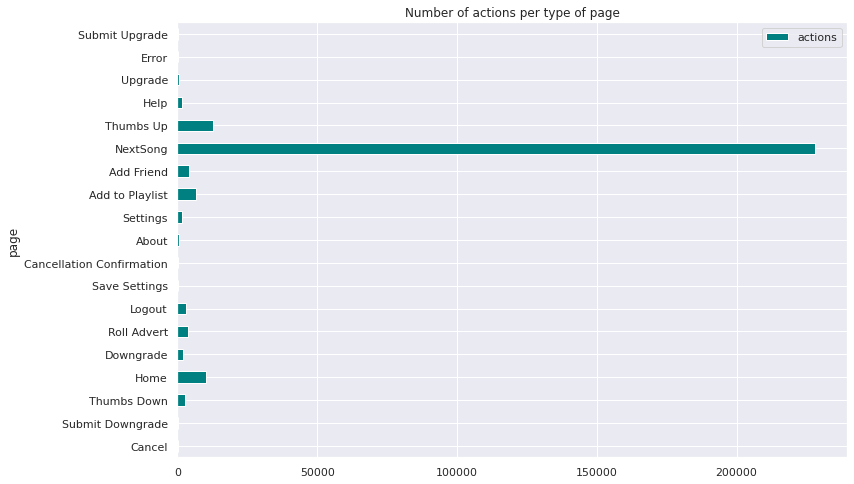

In [53]:
pages_df.toPandas().set_index('page').plot.barh(figsize=(12, 8), color='teal', title='Number of actions per type of page');

The page type describes the actions the user is making on the platform. To analyze the types of actions users are making may be interesting for a future in-depth research. At the moment, let us see if the number of `Thumbs Up`/`Thumbs Down` can be related to user churn.

In [54]:
votes_df = spark.sql('''
          SELECT 
              userId,
              churn_flag,
              COUNT(IF(page = 'Thumbs Up', page, NULL))     AS thumbs_up,
              COUNT(IF(page = 'Thumbs Down', page, NULL))   AS thumbs_down
          FROM user_log_table
          GROUP BY 
              userId,
              churn_flag
          '''
         ).toPandas()

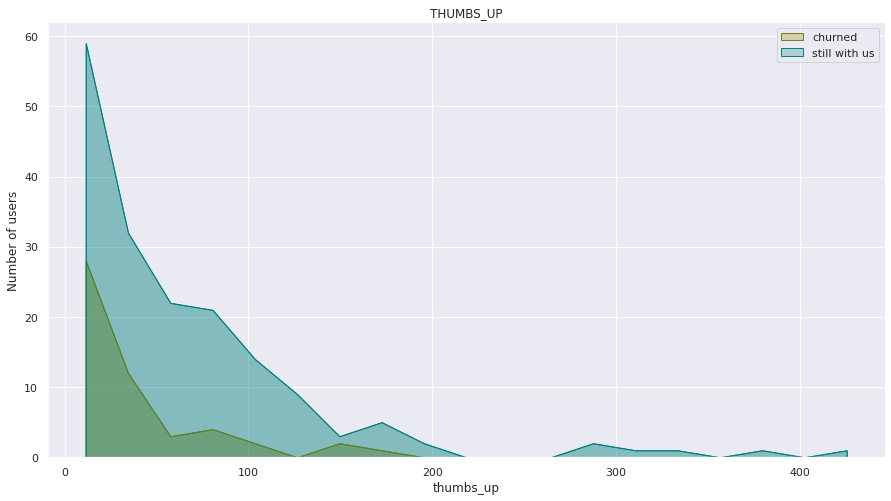

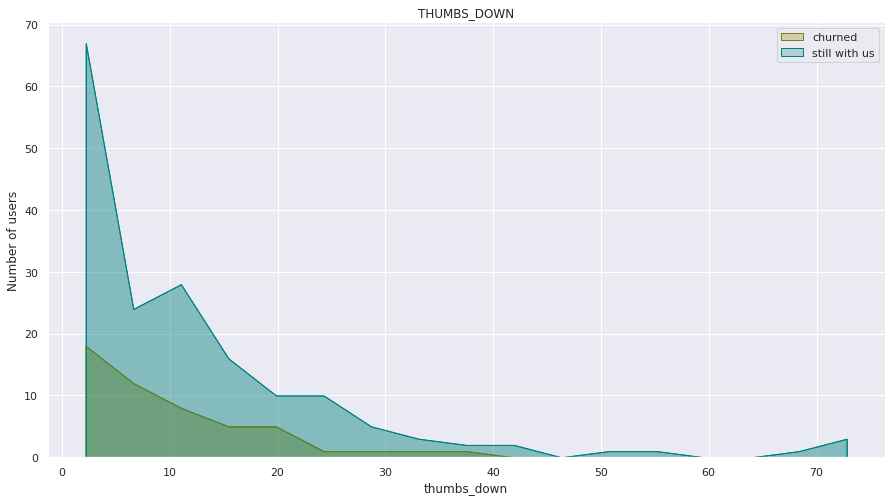

In [55]:
plot_hist(votes_df, 'thumbs_up')
plot_hist(votes_df, 'thumbs_down')

### 4.9. User Session related analysis
___

#### 4.9.1. Song related variables analysis
___

In [56]:
sessions_stats_df = spark.sql('''
              WITH sessions_stats AS (
                  SELECT
                      userId,
                      churn_flag,
                      sessionId,
                      COUNT(*)                                                       AS actions,
                      COUNT(song)                                                    AS plays,
                      COUNT(DISTINCT artist)                                         AS artists,
                      COUNT(IF(page IN ('Thumbs Up', 'Thumbs Down'), page, NULL))    AS votes
                  FROM user_log_table
                  GROUP BY
                      userId,
                      churn_flag,
                      sessionId
              )
              SELECT
                  userId,
                  churn_flag,
                  COUNT(sessionId)                             AS sessions,
                  AVG(actions)                                 AS avg_actions_per_session,
                  AVG(plays)                                   AS avg_plays_per_session,
                  AVG(artists)                                 AS avg_artists_per_session,
                  AVG(votes)                                   AS avg_votes_per_session
              FROM sessions_stats
              GROUP BY
                  userId,
                  churn_flag
              '''
             )

In [57]:
sessions_stats_df.show()

+------+----------+--------+-----------------------+---------------------+-----------------------+---------------------+
|userId|churn_flag|sessions|avg_actions_per_session|avg_plays_per_session|avg_artists_per_session|avg_votes_per_session|
+------+----------+--------+-----------------------+---------------------+-----------------------+---------------------+
|100010|         0|       7|      54.42857142857143|   39.285714285714285|      38.57142857142857|    3.142857142857143|
|200002|         0|       6|                   79.0|                 64.5|     62.166666666666664|                  4.5|
|   125|         1|       1|                   11.0|                  8.0|                    8.0|                  0.0|
|   124|         0|      29|      166.3793103448276|    140.6551724137931|      127.6896551724138|    7.310344827586207|
|    51|         1|      10|                  246.4|                211.1|                  188.2|                 12.1|
|     7|         0|       7|    

In [58]:
sessions_stats_pd = sessions_stats_df.toPandas()

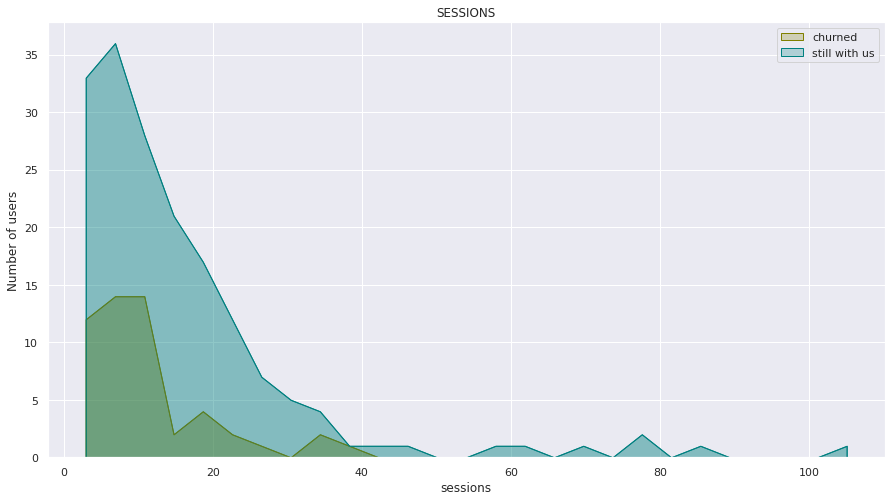

In [59]:
plot_hist(sessions_stats_pd, 'sessions')

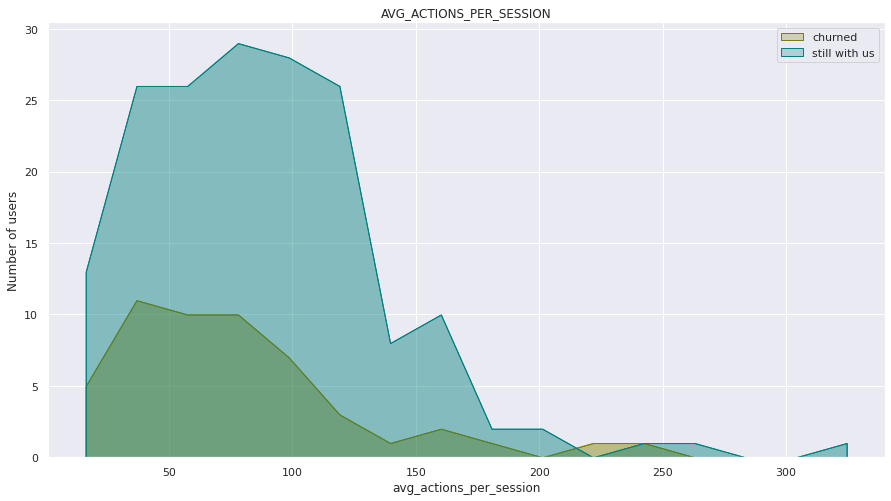

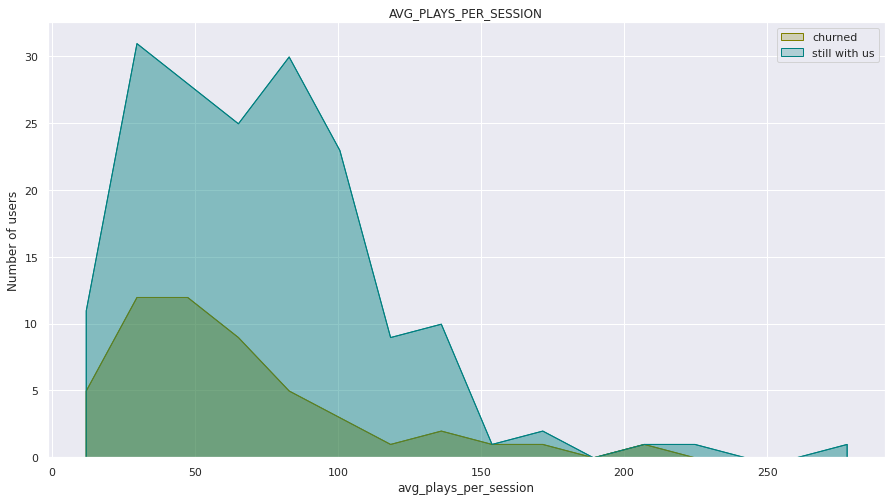

In [60]:
plot_hist(sessions_stats_pd, 'avg_actions_per_session')
plot_hist(sessions_stats_pd, 'avg_plays_per_session')

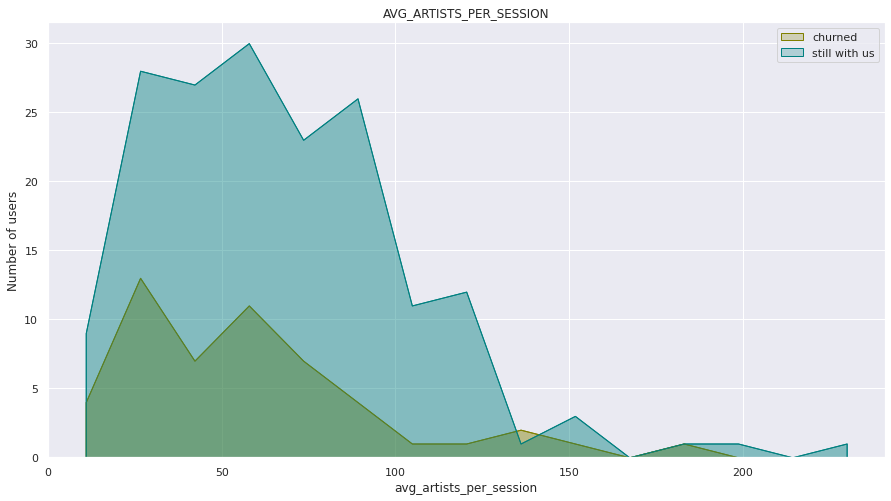

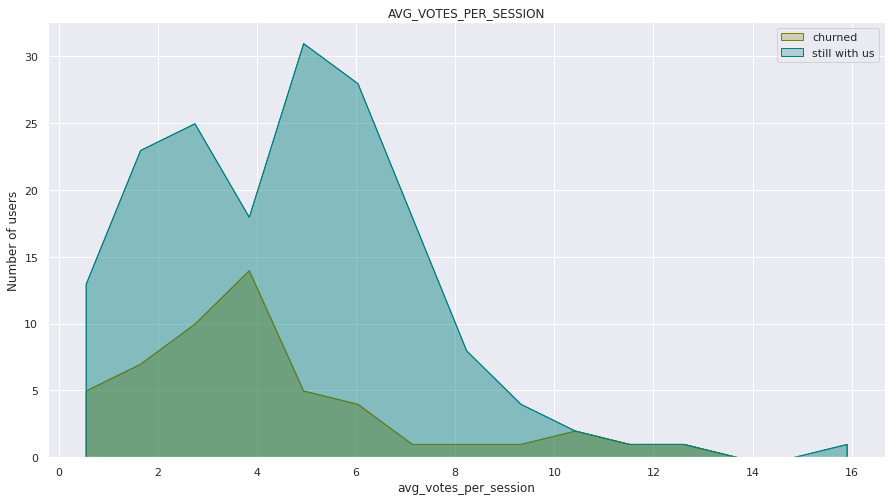

In [61]:
plot_hist(sessions_stats_pd, 'avg_artists_per_session')
plot_hist(sessions_stats_pd, 'avg_votes_per_session')

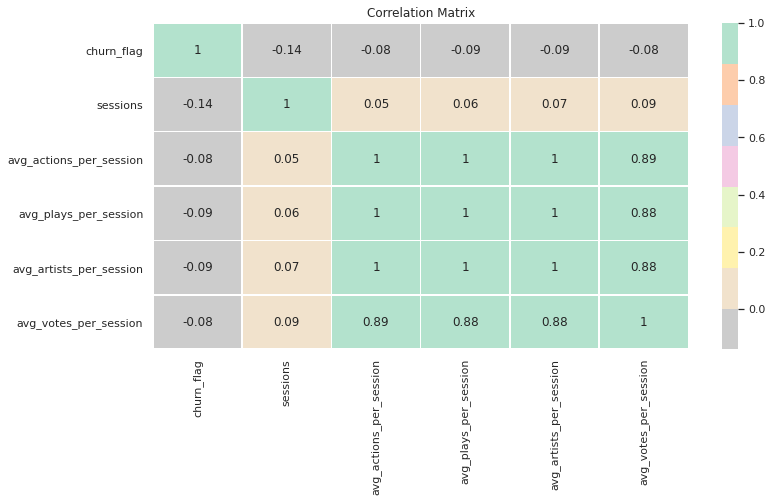

In [62]:
plot_heatmap(sessions_stats_pd.corr())

As in the case of user totals metrics, the pattern is similar for the average counts per user session as well. Therefore, we can consider enough to add the `number of sessions`, `average number of votes per user session` and `average songs played by a user in a session` as features for the model.

#### 4.9.2. Action timestamp analysis
___

In [63]:
user_log.select('ts').show(5)

+-------------+
|           ts|
+-------------+
|1539003534000|
|1539003736000|
|1539003932000|
|1539003933000|
|1539004195000|
+-------------+
only showing top 5 rows



Regarding the action timestamp, it would be interesting to analyze:
- session duration
- time between sessions

We can use *minutes* as a unit measure.

In [64]:
time_df = spark.sql('''
                  SELECT
                      userId,
                      churn_flag,
                      sessionId,
                      MIN(ts)                                                                                              AS session_start,
                      MAX(ts)                                                                                              AS session_end,
                      LAG(TIMESTAMP(MAX(ts)/1000)) OVER (PARTITION BY userId ORDER BY MIN(ts))                             AS previous_session_end,
                      MIN(TIMESTAMP(ts/1000))                                                                              AS session_start_timestamp,
                      MAX(TIMESTAMP(ts/1000))                                                                              AS session_end_timestamp,
                      ROUND((MAX(ts) - MIN(ts))/1000/60)                                                                   AS session_duration_in_minutes,
                      ROUND((MIN(ts) - LAG(MAX(ts)) OVER (PARTITION BY userId ORDER BY MIN(ts)))/1000/60)                  AS time_between_sessions_in_minutes
                  FROM user_log_table
                  GROUP BY
                      userId,
                      churn_flag,
                      sessionId
                  '''
                 )

In [65]:
time_df.show()

+------+----------+---------+-------------+-------------+--------------------+-----------------------+---------------------+---------------------------+--------------------------------+
|userId|churn_flag|sessionId|session_start|  session_end|previous_session_end|session_start_timestamp|session_end_timestamp|session_duration_in_minutes|time_between_sessions_in_minutes|
+------+----------+---------+-------------+-------------+--------------------+-----------------------+---------------------+---------------------------+--------------------------------+
|100010|         0|       31|1539003534000|1539010247000|                null|    2018-10-08 12:58:54|  2018-10-08 14:50:47|                      112.0|                            null|
|100010|         0|       78|1539603322000|1539604675000| 2018-10-08 14:50:47|    2018-10-15 11:35:22|  2018-10-15 11:57:55|                       23.0|                          9885.0|
|100010|         0|      113|1539699018000|1539707924000| 2018-10-15 1

In [66]:
time_df.createOrReplaceTempView("time_table")

In [67]:
time_stats_df = spark.sql('''
                          SELECT
                              userId,
                              churn_flag,
                              (MAX(session_end) - MIN(session_start))/1000/60         AS time_active_in_minutes,
                              SUM(session_duration_in_minutes)                        AS total_time_spent_in_minutes,
                              IFNULL(SUM(time_between_sessions_in_minutes), 0)        AS total_time_between_sessions_in_minutes,
                              AVG(session_duration_in_minutes)                        AS avg_session_duration_in_minutes,
                              IFNULL(AVG(time_between_sessions_in_minutes), 0)        AS avg_time_between_sessions_in_minutes
                          FROM time_table
                          GROUP BY
                              userId,
                              churn_flag
                          '''
                         )

In [68]:
time_stats_df.show()

+------+----------+----------------------+---------------------------+--------------------------------------+-------------------------------+------------------------------------+
|userId|churn_flag|time_active_in_minutes|total_time_spent_in_minutes|total_time_between_sessions_in_minutes|avg_session_duration_in_minutes|avg_time_between_sessions_in_minutes|
+------+----------+----------------------+---------------------------+--------------------------------------+-------------------------------+------------------------------------+
|100010|         0|     63673.63333333333|                     1081.0|                               62593.0|             154.42857142857142|                  10432.166666666666|
|200002|         0|               65515.4|                     1598.0|                               63916.0|              266.3333333333333|                             12783.2|
|   125|         1|    29.566666666666666|                       30.0|                                   

In [69]:
time_stats_pd = time_stats_df.toPandas()

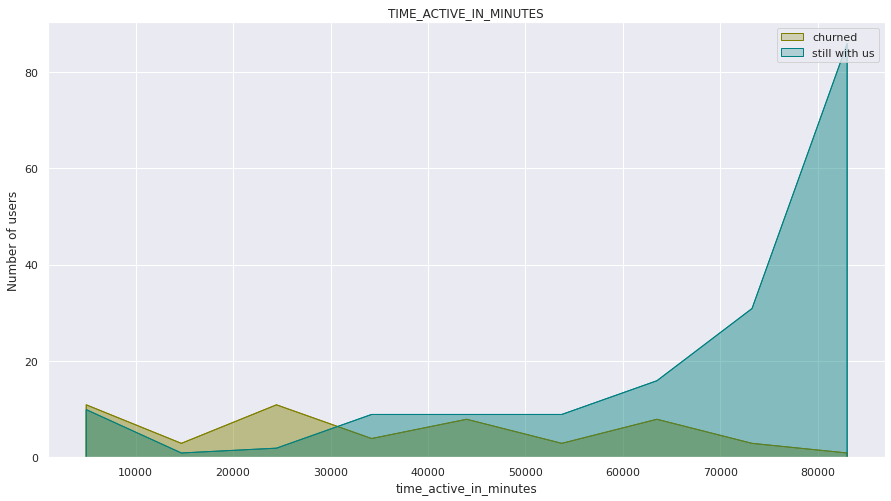

In [70]:
plot_hist(time_stats_pd, 'time_active_in_minutes')

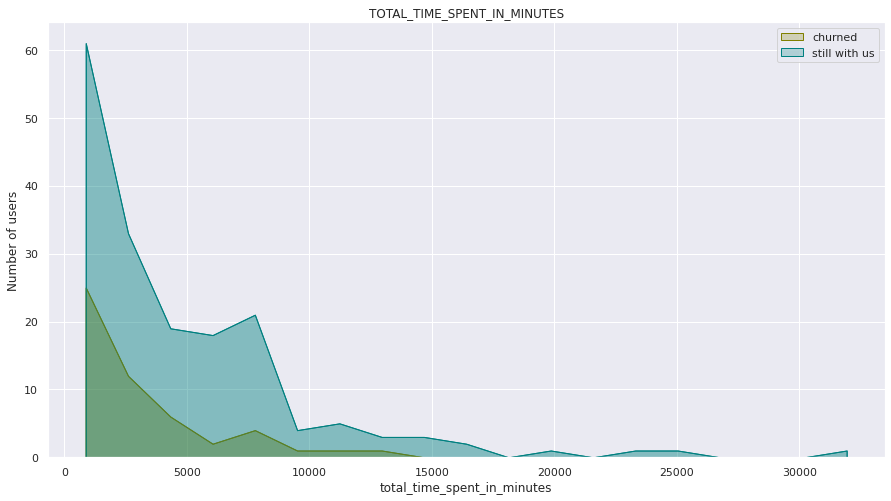

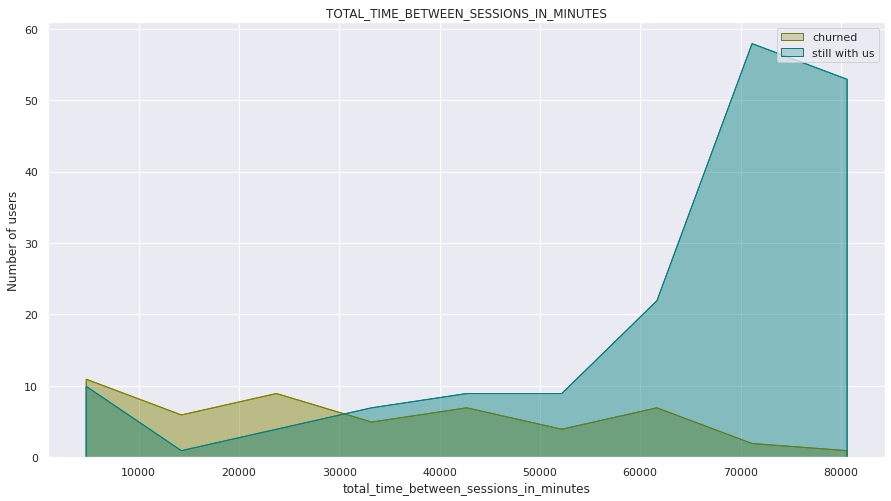

In [71]:
plot_hist(time_stats_pd, 'total_time_spent_in_minutes')
plot_hist(time_stats_pd, 'total_time_between_sessions_in_minutes')

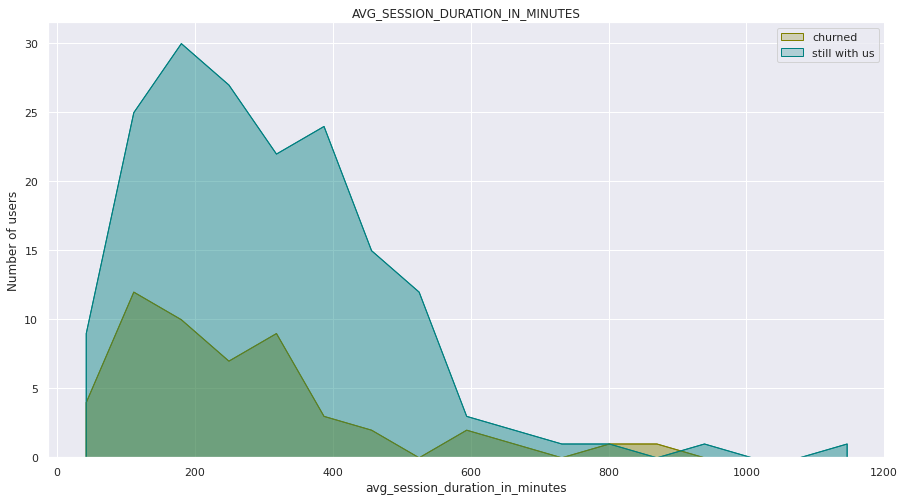

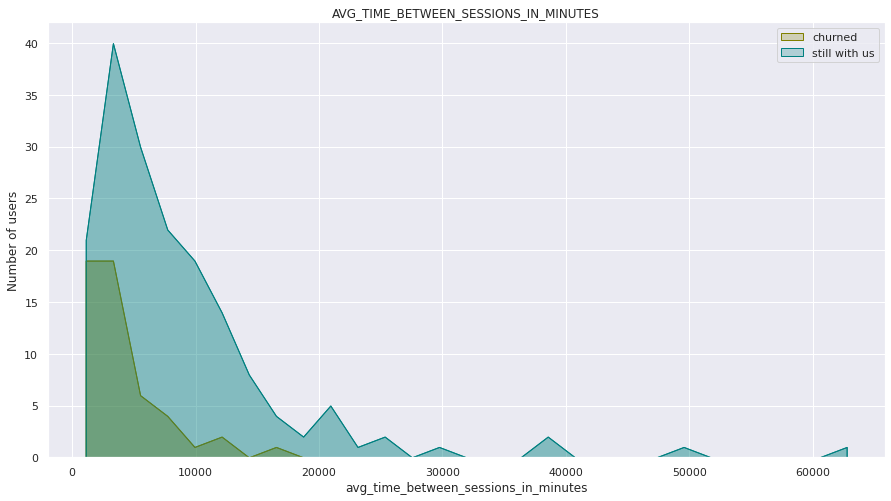

In [72]:
plot_hist(time_stats_pd, 'avg_session_duration_in_minutes')
plot_hist(time_stats_pd, 'avg_time_between_sessions_in_minutes')

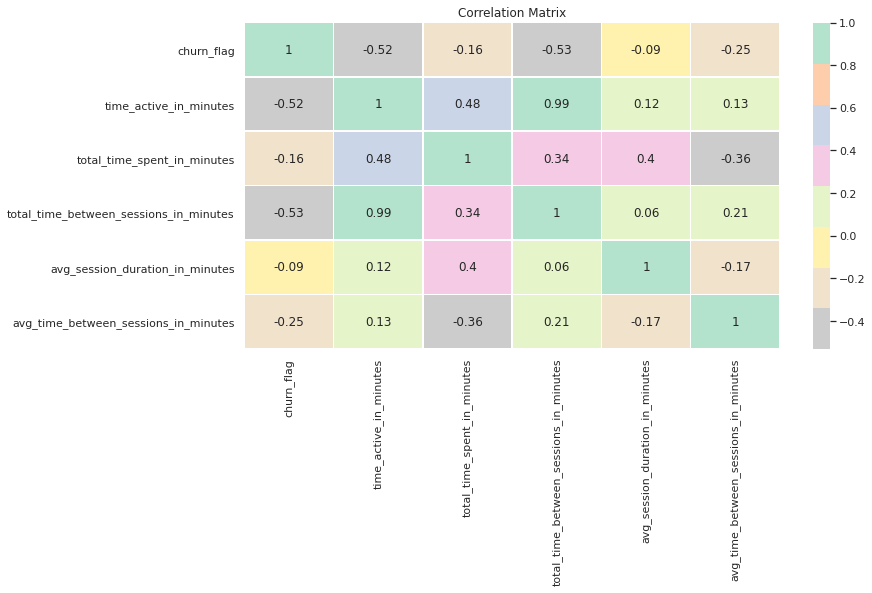

In [73]:
plot_heatmap(time_stats_pd.corr())

One interesting finding here is that users that are active still seem to have more days since they opened the account on the music streaming platform compared to the ones that cancelled it. This will be added to the features list together with total time spent and the average time between sessions.

## 5. Feature Engineering
___

### 5.1. Selecting the features
___

As discussed in the data analysis part of the notebook, it makes sense to use as features for the model the following stats, computed at user level:
- **last_level**
    - the most recent level(free/paid)
    - more accurately, it represents the last level a churned user had or the current level an active user has 
    - as discussed, it better defines an user at the present moment or at the moment of churn
- **sessions***
    - the total number of sessions an user had on our platform
- **total_time_spent_in_minutes**
    - the total time(in minutes) spent on the music streaming platform
- **time_active_in_minutes**
    - the total time(in minutes) that has passed between first action and last action of an user
    - as seen in the plots, the pattern for churned users is different from the one for active users
- **avg_time_between_sessions_in_minutes**
    - the average time between two sessions
    - in other words, it represents the average break a user takes from using our platform
    - if an user had only one session, then the value will be 0
- **avg_plays_per_session***
    - average number of songs a user plays in a session
- **avg_votes_per_session***
    - average number of votes(thumbs up/down) a user gives in a session (user involvement)

**we assume the more sessions or average plays/votes an user has, the more interested can be; similar variables had similar distribution patterns (high correlations), so only these were kept to reduce the number of features*

In [74]:
df = spark.sql('''
          WITH
              user_details AS (
                  SELECT DISTINCT
                      userId,
                      churn_flag,
                      LAST_VALUE(level) OVER (PARTITION BY userId ORDER BY ts ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)   AS last_level
                  FROM user_log_table
              ),
              sessions_stats AS (
                  SELECT
                      userId,
                      sessionId,
                      MIN(ts)                                                                              AS session_start,
                      MAX(ts)                                                                              AS session_end,
                      ROUND((MAX(ts) - MIN(ts))/1000/60)                                                   AS time_spent_in_minutes,
                      ROUND((MIN(ts) - LAG(MAX(ts)) OVER (PARTITION BY userId ORDER BY MIN(ts)))/1000/60)  AS time_between_sessions_in_minutes,                                                                             
                      COUNT(song)                                                                          AS plays,
                      COUNT(IF(page IN ('Thumbs Up', 'Thumbs Down'), page, NULL))                          AS votes
                  FROM user_log_table
                  GROUP BY
                      userId,
                      sessionId
          )
          SELECT 
              user.userId,
              churn_flag,
              last_level,
              COUNT(sessionId)                                        AS sessions,
              SUM(time_spent_in_minutes)                              AS total_time_spent_in_minutes,
              (MAX(session_end) - MIN(session_start))/1000/60         AS time_active_in_minutes,
              IFNULL(AVG(time_between_sessions_in_minutes), 0)        AS avg_time_between_sessions_in_minutes,
              AVG(plays)                                              AS avg_plays_per_session,
              AVG(votes)                                              AS avg_votes_per_session
          FROM user_details      AS user
          JOIN sessions_stats    AS session
              ON user.userId = session.userId
          GROUP BY 
              user.userId,
              churn_flag,
              last_level
          '''
         )

In [75]:
df.show()

+------+----------+----------+--------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+
|userId|churn_flag|last_level|sessions|total_time_spent_in_minutes|time_active_in_minutes|avg_time_between_sessions_in_minutes|avg_plays_per_session|avg_votes_per_session|
+------+----------+----------+--------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+
|100010|         0|      free|       7|                     1081.0|     63673.63333333333|                  10432.166666666666|   39.285714285714285|    3.142857142857143|
|200002|         0|      paid|       6|                     1598.0|               65515.4|                             12783.2|                 64.5|                  4.5|
|   125|         1|      free|       1|                       30.0|    29.566666666666666|                                 0.0|             

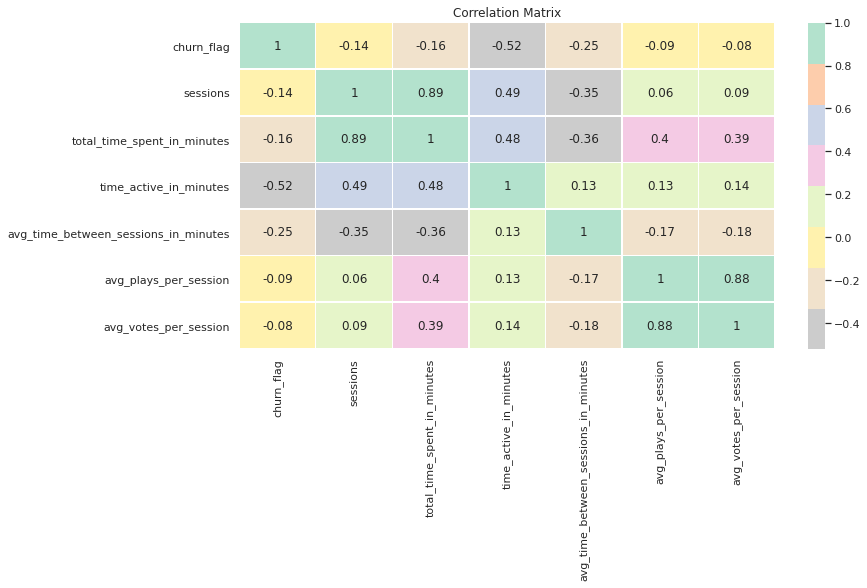

In [76]:
plot_heatmap(df.toPandas().corr())

### 5.2. Encoding categorical data and feature scaling
___

For scaling, I will create a `CustomScaler`, at the moment tailored for our data. 

There is only one categorical variable to encode(`last_level`) and since it can have only two values, I will encode one value with `0` and the othter with `1`. 

For continuous features scaling, I will use *z-score normalization* - for each value we subtract the feature mean and divide by the standard deviation. This makes the values of each feature have the mean equal to `0` and the standard deviation equal to `1`

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b0aa2e7d203db1526c577192f2d9102b718eafd5" width="100px">

In [77]:
class CustomScaler(Transformer):
    
    def __init__(self, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.stats_df_ = None
    
    def fit(self, df):
        
        df.createOrReplaceTempView("df_temp_view")
        
        self.stats_df_ = spark.sql(f'''
                                    SELECT
                                        AVG(sessions)                                            AS mean_sessions,
                                        STDDEV(sessions)                                         AS std_sessions,
                                        AVG(total_time_spent_in_minutes)                         AS mean_total_time_spent_in_minutes,
                                        STDDEV(total_time_spent_in_minutes)                      AS std_total_time_spent_in_minutes,
                                        AVG(time_active_in_minutes)                              AS mean_time_active_in_minutes,
                                        STDDEV(time_active_in_minutes)                           AS std_time_active_in_minutes,
                                        AVG(avg_time_between_sessions_in_minutes)                AS mean_avg_time_between_sessions_in_minutes,
                                        STDDEV(avg_time_between_sessions_in_minutes)             AS std_avg_time_between_sessions_in_minutes,
                                        AVG(avg_plays_per_session)                               AS mean_avg_plays_per_session,
                                        STDDEV(avg_plays_per_session)                            AS std_avg_plays_per_session,
                                        AVG(avg_votes_per_session)                               AS mean_avg_votes_per_session,
                                        STDDEV(avg_votes_per_session)                            AS std_avg_votes_per_session
                                    FROM df_temp_view
                                    '''
                                    )
        
    def transform(self, df):
        
        if not self.stats_df_:
            raise ValueError("CustomScaler is not fitted. Call 'fit' before using transform")
        
        df.createOrReplaceTempView("df_temp_view")
        self.stats_df_.createOrReplaceTempView("stats_temp_view")
    
        scaled_df = spark.sql(f'''
                    SELECT 
                        userId,
                        IF(last_level = 'paid', 0, 1)                                                                                                               AS last_level,
                        (sessions - mean_sessions)/std_sessions                                                                                                     AS sessions,
                        (total_time_spent_in_minutes - mean_total_time_spent_in_minutes)/std_total_time_spent_in_minutes                                            AS total_time_spent_in_minutes,
                        (time_active_in_minutes - mean_time_active_in_minutes)/std_time_active_in_minutes                                                           AS time_active_in_minutes,
                        (avg_time_between_sessions_in_minutes - mean_avg_time_between_sessions_in_minutes)/std_avg_time_between_sessions_in_minutes                 AS avg_time_between_sessions_in_minutes,
                        (avg_plays_per_session - mean_avg_plays_per_session)/std_avg_plays_per_session                                                              AS avg_plays_per_session,
                        (avg_votes_per_session - mean_avg_votes_per_session)/std_avg_votes_per_session                                                              AS avg_votes_per_session,
                        churn_flag                                                                                                                                  AS label
                    FROM df_temp_view
                    CROSS JOIN stats_temp_view
                  '''
                 )
        
        return scaled_df

Before using the scaler, I will make the train/test split.

The scaler will be fit only on training data, and then it will be used to transform both training and test data. *"This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage."[[1]](https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split)*

In [78]:
train, test = df.randomSplit([0.8, 0.2], seed=42)

In [79]:
scaler = CustomScaler()
scaler.fit(train)

In [80]:
train.show(10)

+------+----------+----------+--------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+
|userId|churn_flag|last_level|sessions|total_time_spent_in_minutes|time_active_in_minutes|avg_time_between_sessions_in_minutes|avg_plays_per_session|avg_votes_per_session|
+------+----------+----------+--------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+
|100010|         0|      free|       7|                     1081.0|     63673.63333333333|                  10432.166666666666|   39.285714285714285|    3.142857142857143|
|   125|         1|      free|       1|                       30.0|    29.566666666666666|                                 0.0|                  8.0|                  0.0|
|   124|         0|      paid|      29|                    16791.0|               86395.6|                  2485.8214285714284|    140.65517

In [81]:
train = scaler.transform(train)
train.show(10)

+------+----------+--------------------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+-----+
|userId|last_level|            sessions|total_time_spent_in_minutes|time_active_in_minutes|avg_time_between_sessions_in_minutes|avg_plays_per_session|avg_votes_per_session|label|
+------+----------+--------------------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+-----+
|100010|         1|-0.48034852173636805|        -0.6580189681934003|   0.17070912862868218|                  0.4477156934280469|  -0.7285896183241037|  -0.5219911657027289|    0|
|   125|         1| -0.8669211382461137|        -0.8801217099272453|   -2.0922912934886937|                 -0.9120389563614134|  -1.5500589136660594|  -1.7930109647462333|    1|
|   124|         0|  0.9370844054660327|         2.6618992740889067|     0.978637076214322|              

In [82]:
test.show(10)

+------+----------+----------+--------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+
|userId|churn_flag|last_level|sessions|total_time_spent_in_minutes|time_active_in_minutes|avg_time_between_sessions_in_minutes|avg_plays_per_session|avg_votes_per_session|
+------+----------+----------+--------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+
|200002|         0|      paid|       6|                     1598.0|               65515.4|                             12783.2|                 64.5|                  4.5|
|    51|         1|      paid|      10|                     8724.0|    22722.333333333332|                  1555.3333333333333|                211.1|                 12.1|
|    15|         0|      paid|      15|                     7926.0|     78873.38333333333|                   5067.785714285715|             

In [83]:
test = scaler.transform(test)
test.show(10)

+------+----------+--------------------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+-----+
|userId|last_level|            sessions|total_time_spent_in_minutes|time_active_in_minutes|avg_time_between_sessions_in_minutes|avg_plays_per_session|avg_votes_per_session|label|
+------+----------+--------------------+---------------------------+----------------------+------------------------------------+---------------------+---------------------+-----+
|200002|         0|  -0.544777291154659|        -0.5487638611749437|    0.2361970674484578|                  0.7541552480245689| -0.06653788029736778|  0.02685829297514802|    0|
|    51|         0|-0.28706221348149524|         0.9571392193154268|   -1.2854016141311346|                 -0.7093129264245955|    3.782739703629184|   3.1004152615712584|    1|
|    15|         0| 0.03508163360995947|         0.7885017427182733|    0.7111686320452655|              

## 6. Model Training
___

### 6.1. Preparation
___

**Features**

In [84]:
features = [col for col in df.columns if col not in ('userId', 'churn_flag')] 

In [85]:
features

['last_level',
 'sessions',
 'total_time_spent_in_minutes',
 'time_active_in_minutes',
 'avg_time_between_sessions_in_minutes',
 'avg_plays_per_session',
 'avg_votes_per_session']

**Evaluation Metrics**

The classes are inbalanced, meaning that we have 3x more active users than users that have cancelled the account. 

Keeping this in mind and considering we want to find as many users as possible that are likely to leave, the objective being to get a good precision score for the negative class (`churn_flag=1`).
*"Precision is the estimated probability that a document randomly selected from the pool of retrieved documents is relevant."*[[2]](https://en.wikipedia.org/wiki/Precision_and_recall) We should check the recall score as well, but it is not the case to be as focused on it, since it shouldn't be much of a problem if we will give discounts and offers to active users that are actually not that likely to cancel. As for a metric to evaluate the Spark models, I will choose *areaUnderPR* (are under precision-recall curve), having in mind the same considerations. *"According to Saito and Rehmsmeier, precision-recall plots are more informative than ROC plots when evaluating binary classifiers on imbalanced data."*[[2]](https://en.wikipedia.org/wiki/Precision_and_recall)

In [86]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')

**Models, training and results**

In [87]:
def get_model(features, classifier, parameters_grid, evaluator):
    '''
    Returns an instance of a CrossValidator model, to be trained
    
    Input
    -----
    features: list[string]
        list of strings, containing the name of the features
    classifier
        instance of a classifier to be trained
        any SparkML classifier suited for binary classification allowed
    parameters_grid: ParamGridBuilder instance
        grid of parameters to be tried for fine tuning purposes 
        one model will be trained for each combination 
        the model will choose the params for which the model is the most performant
    evaluator: BinaryClassificationEvaluator instance
        evaluator for chosing the most performant model
        
    Output
    ------
    model: CrossValidator instance
        the model to be trained
    '''
    
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    pipeline  = Pipeline(stages=[assembler, classifier])
    
    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=parameters_grid,
        evaluator=evaluator,
        numFolds=5,
    )
    
    return model

In [88]:
def train_and_predict(model, train=train, test=test):
    '''
    Trains a model on training data and returns predicted results for test data
    
    Input
    -----
    model: CrossValidator instance
        the model to be trained
    train: Spark DataFrame
        train dataset, preprocessed and scaled
    test: Spark DataFrame
        test dataset, preprocessed and scaled
    
    Output
    ------
    test_results: Spark DataFrame
        test dataset together with predictions
    '''
    
    trained_model = model.fit(train)
    test_results = trained_model.transform(test)
    
    return test_results

In [89]:
def get_precision(test_results, label, print_classification_report=False):
    '''
    Returns precision score for a class and, if needed, prints the classification report for that class
    
    Input
    -----
    test_results: Spark DataFrame
        test dataset together with predictions  
    label: int
        0 or 1, representing the class for which we need the results
       (0=positive class, active users; 1=negative class, users that churned)
    print_classification_report: bool
        if True, print the classification report for the label class
        classification report contains precision, recall and f1 score for a class
    '''
    
    if label == 0:
        name = 'positive'
        negative_label = 1
    else:
        name = 'negative'
        negative_label= 0
    
    tp = test_results.filter((test_results.label == label) & (test_results.label == test_results.prediction)).count()
    fp = test_results.filter((test_results.label == label) & (test_results.label != test_results.prediction)).count()
    tn = test_results.filter((test_results.label == negative_label) & (test_results.label == test_results.prediction)).count()
    fn = test_results.filter((test_results.label == negative_label) & (test_results.label != test_results.prediction)).count()

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = (2 * precision * recall)/(precision + recall)

    if print_classification_report:    
        print(f'''
              precision for {name} class: {precision}
              recall for {name} class: {recall}
              f1 score for {name} class: {f1}
              '''
             )
    
    return precision

Creating one pandas dataframe in which to store the model results
- classifier name
- evaluator score - areaUnderPR
- goal metric value - precision for the negative class

In [90]:
results = pd.DataFrame(columns=['classifier', 'areaUnderPR_score', 'churn_class_precision'])

### 6.2. Training
___

As seen in the functions definitions above, the approach is a *trial and error* one, meaning that the plan is to train several types of models (in the future and on the full dataset, with different parameters and maybe with different features as well), until we find the best performing one.

First, using the classifiers with the default parameters

In [91]:
grid = ParamGridBuilder().build()

**Logistic Regression**

In [92]:
lr_classifier = LogisticRegression()

In [93]:
lr_model = get_model(features, lr_classifier, grid, evaluator)

In [94]:
lr_test_results = train_and_predict(lr_model)

In [95]:
get_precision(lr_test_results, label=0, print_classification_report=True)
churn_class_precision = get_precision(lr_test_results, label=1, print_classification_report=True)


              precision for positive class: 1.0
              recall for positive class: 0.8125
              f1 score for positive class: 0.896551724137931
              

              precision for negative class: 0.25
              recall for negative class: 1.0
              f1 score for negative class: 0.4
              


In [96]:
lr_test_results.filter(lr_test_results.label == 1).select('userId', 'label', 'probability', 'prediction').show(truncate=False)

+------+-----+----------------------------------------+----------+
|userId|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|51    |1    |[0.6358254068344995,0.3641745931655005] |0.0       |
|3     |1    |[0.7268024608012179,0.27319753919878204]|0.0       |
|100022|1    |[0.841792247454317,0.158207752545683]   |0.0       |
|100005|1    |[0.62970471664118,0.37029528335881995]  |0.0       |
|100009|1    |[0.7232069314677957,0.27679306853220437]|0.0       |
|100015|1    |[0.8990585357555,0.10094146424449997]   |0.0       |
|122   |1    |[0.3449899924174356,0.6550100075825643] |1.0       |
|200001|1    |[0.46275393711480695,0.5372460628851929]|1.0       |
+------+-----+----------------------------------------+----------+



In [97]:
results = results.append({'classifier' : 'Logistic Regression',
                          'areaUnderPR_score' : evaluator.evaluate(lr_test_results),
                          'churn_class_precision' : get_precision(lr_test_results, label=1),
                         },
                         ignore_index=True
                        )

**Decision Tree Classifier**

In [98]:
tree_classifier = DecisionTreeClassifier()

In [99]:
tree_model = get_model(features, tree_classifier, grid, evaluator)

In [100]:
tree_test_results = train_and_predict(tree_model)

In [101]:
get_precision(tree_test_results, label=0, print_classification_report=True)
churn_class_precision = get_precision(tree_test_results, label=1, print_classification_report=True)


              precision for positive class: 0.9230769230769231
              recall for positive class: 0.8888888888888888
              f1 score for positive class: 0.9056603773584906
              

              precision for negative class: 0.625
              recall for negative class: 0.7142857142857143
              f1 score for negative class: 0.6666666666666666
              


In [102]:
tree_test_results.filter(tree_test_results.label == 1).select('userId', 'label', 'probability', 'prediction').show(truncate=False)

+------+-----+-----------------------------------------+----------+
|userId|label|probability                              |prediction|
+------+-----+-----------------------------------------+----------+
|51    |1    |[0.0,1.0]                                |1.0       |
|3     |1    |[1.0,0.0]                                |0.0       |
|100022|1    |[0.1875,0.8125]                          |1.0       |
|100005|1    |[0.0,1.0]                                |1.0       |
|100009|1    |[0.1875,0.8125]                          |1.0       |
|100015|1    |[0.9888888888888889,0.011111111111111112]|0.0       |
|122   |1    |[1.0,0.0]                                |0.0       |
|200001|1    |[0.0,1.0]                                |1.0       |
+------+-----+-----------------------------------------+----------+



In [111]:
results = results.append({'classifier' : 'Decision Tree',
                          'areaUnderPR_score' : evaluator.evaluate(tree_test_results),
                          'churn_class_precision' : get_precision(tree_test_results, label=1),
                         },
                         ignore_index=True
                        )

**Linear Support Vector Machine**

In [104]:
svc_classifier = LinearSVC(maxIter=10)

In [105]:
svc_model = get_model(features, svc_classifier, grid, evaluator)

In [106]:
svc_test_results = train_and_predict(svc_model)

In [107]:
get_precision(svc_test_results, label=0, print_classification_report=True)
churn_class_precision = get_precision(svc_test_results, label=1, print_classification_report=True)


              precision for positive class: 1.0
              recall for positive class: 0.8387096774193549
              f1 score for positive class: 0.9122807017543859
              

              precision for negative class: 0.375
              recall for negative class: 1.0
              f1 score for negative class: 0.5454545454545454
              


In [108]:
svc_test_results.filter(svc_test_results.label == 1).select('userId', 'label', 'rawPrediction', 'prediction').show(truncate=False)

+------+-----+------------------------------------------+----------+
|userId|label|rawPrediction                             |prediction|
+------+-----+------------------------------------------+----------+
|51    |1    |[-0.08905171066687101,0.08905171066687101]|1.0       |
|3     |1    |[0.6664276205125556,-0.6664276205125556]  |0.0       |
|100022|1    |[0.9081694266873985,-0.9081694266873985]  |0.0       |
|100005|1    |[0.1713627305571398,-0.1713627305571398]  |0.0       |
|100009|1    |[0.3677487499875168,-0.3677487499875168]  |0.0       |
|100015|1    |[1.274025702191454,-1.274025702191454]    |0.0       |
|122   |1    |[-0.39394367399031716,0.39394367399031716]|1.0       |
|200001|1    |[-0.23806219062634082,0.23806219062634082]|1.0       |
+------+-----+------------------------------------------+----------+



In [109]:
results = results.append({'classifier' : 'Support Vector Machine',
                          'areaUnderPR_score' : evaluator.evaluate(svc_test_results),
                          'churn_class_precision' : get_precision(svc_test_results, label=1),
                         },
                         ignore_index=True
                        )

### 6.3. Results
___

In [110]:
results

,classifier,areaUnderPR_score,churn_class_precision
0,Logistic Regression,0.918676,0.250
1,Decision Tree,0.708340,0.625
2,Support Vector Machine,0.944368,0.375


It looks like the logistic regression and the support vector machine models tended to predict that almost all users are active and are not going to leave, while the decision tree model performed best, being able to detect 5 out of 8 churned users.